In [1]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

C:\Users\Anna Vallvé Nicolás\AppData\Local\Temp\ipykernel_23216\893797008.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
# Carrega el CSV
csv_file = 'Dataset_lletres/written_letters_train_v3.csv'  # Canvia aquest nom segons sigui necessari
df = pd.read_csv(csv_file)

# Divideix en conjunts de train i test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['nombre'])

# Crea les carpetes de destinació si no existeixen
train_dir = 'train_images'
test_dir = 'test_images'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Funció per moure les imatges i actualitzar els camins al dataframe
def move_images(df, dest_dir):
    new_paths = []
    for _, row in df.iterrows():
        src_path = row['id']
        filename = os.path.basename(src_path)
        dest_path = os.path.join(dest_dir, filename)
        shutil.copy2("Dataset_lletres/imatges_proc1/"+str(src_path), dest_path)  # Copia l'arxiu
        new_paths.append(dest_path)
    df['Path'] = new_paths
    return df

# Mou les imatges i actualitza els camins
train_df = move_images(train_df, train_dir)
test_df = move_images(test_df, test_dir)

# Guarda els nous CSVs
train_csv = 'train_labels.csv'
test_csv = 'test_labels.csv'
train_df.to_csv(train_csv, index=False)
test_df.to_csv(test_csv, index=False)

print(f"Imatges de train guardades a {train_dir} i etiquetes a {train_csv}")
print(f"Imatges de test guardades a {test_dir} i etiquetes a {test_csv}")


KeyboardInterrupt: 

In [5]:
# Funció per carregar les imatges i les etiquetes
def load_data(csv_file, img_size=(28, 28)):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = row['Path']
        label = row['nombre']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalitza la imatge
        images.append(img)
        labels.append(label)
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    labels = np.array(labels)
    return images, labels

# Carrega les dades de train i test
train_images, train_labels = load_data('train_labels.csv')
test_images, test_labels = load_data('test_labels.csv')


In [7]:
# Crea un diccionari de mapping de lletres a enters
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ- '"
letter_to_int = {letter: idx for idx, letter in enumerate(letters)}

# Defineix el dataset personalitzat
class LettersDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['Path']
        image = Image.open(img_path).convert('RGB')
        label = letter_to_int[self.data.iloc[idx]['nombre']]  # Converteix la lletra a un integer
        
        if self.transform:
            image = self.transform(image)
        return image, label

# Defineix les transformacions
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Crea els datasets i dataloaders
train_dataset = LettersDataset('train_labels.csv', transform=transform)
test_dataset = LettersDataset('test_labels.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Defineix el model
class SimpleCNN(nn.Module): 
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 3 canals de color (RGB) i amb aquesta capa convolucional 
        s'estreuen característiques loclas de la imatge detectant patrons com bordes, 
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques, 
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen 
        les característiques extretes per les capas convolucionals i de pooling a les 
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x2

# Instancia el model, defineix la pèrdua i l'optimitzador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Entrenament del model
num_epochs = 10
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels = torch.tensor(labels, dtype=torch.long)  # Assegura't que els labels són tensors de tipus long
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calcular la precisión y la pérdida promedio en cada época
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    # Guardar la pérdida y la precisión en las listas
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

# Exemple d'ús amb les prediccions del model
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')

# Avaluació del model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

C:\Users\Anna Vallvé Nicolás\AppData\Local\Temp\ipykernel_23216\1143645781.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)  # Assegura't que els labels són tensors de tipus long


Epoch 1/10, Loss: 0.8487554670957115
Epoch 2/10, Loss: 0.5806661885548313
Epoch 3/10, Loss: 0.5127451813942541
Epoch 4/10, Loss: 0.4704132798177109
Epoch 5/10, Loss: 0.44080730516290295
Epoch 6/10, Loss: 0.4205772447674065
Epoch 7/10, Loss: 0.4041604745619393
Epoch 8/10, Loss: 0.3916286586498606
Epoch 9/10, Loss: 0.3809171367251478
Epoch 10/10, Loss: 0.3725104495825247
Nombre de lletres correctes: 27090
Percentatge de lletres correctes: 90.49305184393373%
Accuracy of the model on the test images: 90.49305184393373%


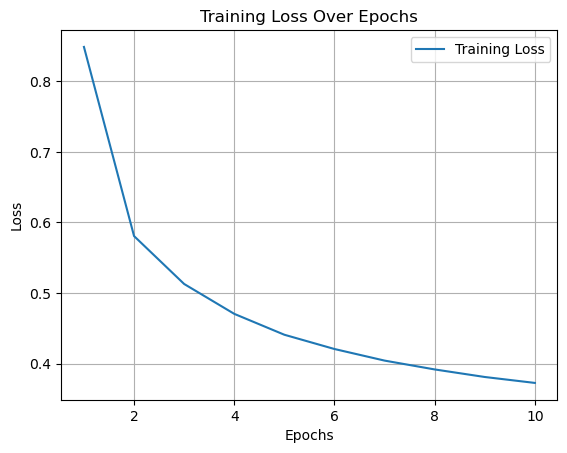

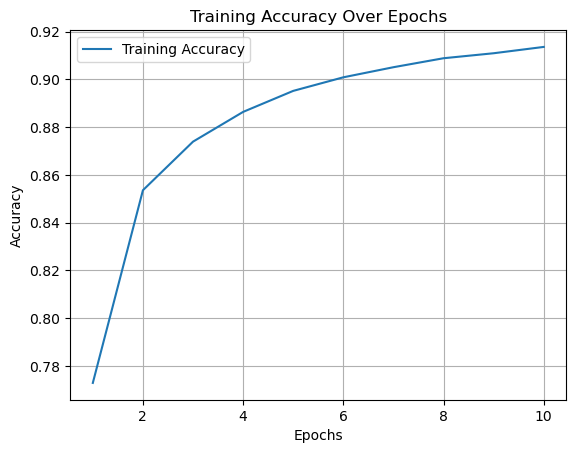

In [8]:
# Crear la gráfica de pérdida
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Crear la gráfica de precisión
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()